# Discussão de casos: Segmentação de Chan-Vese
## Introdução

Este notebook tem por finalidade apresentar e explicar, de forma que o leitor consiga compreender, como o método de Chan-Vese funciona no contexto de segmentação assistida para imagens de ressonância magnética, no problema descrito no [inserir notebook]. Para facilitar a demonstração do [inserir notebook], este notebook será executado em *batch* para um determinado escopo de *slices* de um paciente. Além disso, serão dsicutidos os casos de falha e sucesso das execuções, com uma análise sobre os resultados que seguem.

O roteiro de execução se dá como segue:
* O usuário tendo em mãos um paciente, localiza a lesão de interesse em um determinado slice da aquisição MRI;
* Neste slice em específico, o usuário deve realizar as operações necessárias para a execução do processo de segmentação, isto é, definir possíveis passos de pré-processamento, seus respectivos parâmetros, e demais etapas necessárias para obter-se uma segmentação bem-sucedida da lesão;
* Tendo-se uma imagem preprocessada, o usuário escolhe os parametros $\mu$, $\lambda_{1}$, $\lambda_{2}$, definindo assim o método, e uma *seed*, para conseguir a parte conexa da segmentação.
* Após todos os paremetros serem dados, executa-se o método em questão.
* Dada uma segmentação exitosa, o usuário então informa um escopo de slices, precedentes, posteriores, ou ambos, para o qual o método deve segmentar usando os mesmos parâmetros e ordem de etapas realizados no *slice* de referência.

O objetivo é que, tendo uma segmentação de boa qualidade para um slice referência, os mesmos procedimentos possam ser executados em slices adjacentes, auxiliando no processo de segmentação em sequência.

Ao todo foram analisados 4 casos de teste distintos, variando entre 6 a 9 slices em cada, totalizando juntamente um total de 31 slices. Os casos de teste possuem diferentes níveis de dificuldade para a segmentação, tanto em tamanho das regiões a serem segmentadas, como em complexidade das formas.

Para as execuções apresentadas nesse notebook, cada caso de teste foi executado individualmente e os preprocessamentos e sementes foram definidas para o slice de referência. Desta forma, e etapa de exploração a ser executada pelo usuário já foi efetuada e aqui reproduzimos os resultados posteriores a esse processo.

Para efeito de apresentação, não foram feitos preprocessamentos para este método, de modo a entender como o método funciona por si só.

## Explicação do método

Chan-Vese para contorno ativo é um método muito poderoso e flexível, permitindo segmentações de vários tipos de imagens, podendo ser bem útil quando métodos como thresholding ou gradientes não funcionem tão bem.

Tal modelo se baseia na ideia de minimizar um funcional energia, podendo ser reformulado como curvas de nível, tornando assim mais fácil de resolver o problema.

Como o objetivo é entender a análise de casos do método, apenas uma breve apresentação da ideia do método será mostrada.

Seja C uma curva, $C^{1}[0, 1]$ por partes. Vamos denotar por $\omega$ como região interna de C. Além disso, iremos denotar por $c_{1}$ a intensidade média dos pontos interiores e $c_{2}$ a intensidade externa a curva C.

O objetivo do método é minimizar o funcional energia

$F(c_{1}$, $c_{2}$, C$)$ = $\mu$*Comprimento(C) + $\lambda_{1}$ * $\int$ |Image$[x,y]$ - $c_{1}$|$^{2}dxdy$ + $\lambda_{2}$ * $\int$ |Image$[x,y]$ - $c_{2}$|$^{2}dxdy$

Onde a primeira integral tem como domínio o interior da curva e a segunda, a parte exterior.

Esta é a ideia por trás do método.

# Desenvolvimento

Inicialmente, é realizada a importação das bibliotecas numpy, math e matplotlib, juntamente com os arquivos `utils`, `chan-vese` e o método `chan_vese`, importado de `skimage`, que implementam métodos utilitários e os métodos necessários para execução da segmentaçao.

In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

import matplotlib.pyplot as plt
from skimage.segmentation import chan_vese
import numpy as np
import math

from src import utils
from src import chan_vese
from src import args_test

Inicialmente, definimos uma função para recuperar _slices_ sequenciais de um mesmo paciente. Para tanto, deve ser informado o paciente desejado, o escopo de _slices_ desejado e a perspectiva dos mesmos. Ao final, a função retorna um _array_ com todas as sequências prontas para uso pelo método de segmentação.

O método para obtenção dos _slices_ em _batch_ também pode ser configurado para retornar as máscaras, definindo-se a flag `masks` para `True`. As máscaras retornadas pelo método foram criadas por um humano e são definidas como _groundtruth_ durante as avaliações.

In [2]:
def get_batch_data(df, subject_id, slices_range, perspective, masks=False):
    start_slice, end_slice = slices_range
    slices_array = []
    for n_slice in range(start_slice, end_slice):
        slice_n = utils.get_image(df, subject_id, n_slice, perspective, masks)
        slices_array.append(np.flip(slice_n))

    return slices_array

O método a seguir realiza a execução o método Chan-Vese para o conjunto de slices obtidos por meio do método get_batch_data descrito anteriormente.

In [3]:
def apply_batch_chan_vese(df, subject_id, slices_range, perspective, mu,
                          lambda1, lambda2, x, y, n_case):

    slices_array = get_batch_data(df, subject_id, slices_range, perspective)
    masks_array = get_batch_data(df, subject_id, slices_range, perspective, True)
    mri_norm_array = []
    seg_masks_array = []
    dice_scores = []

    for slice, gt_mask in zip(slices_array, masks_array):
        mri_norm = utils.normalize_img(slice)
        img_seg = chan_vese.apply_chan_vese(mri_norm, (y, x), mu, lambda1, lambda2)

        dice_score = dice_score_similarity(img_seg, gt_mask)
        dice_scores.append(dice_score)
        mri_norm_array.append(mri_norm)
        seg_masks_array.append(img_seg)

    resulting_slices = [mri_norm_array, seg_masks_array, masks_array]
    plot_mosaic(resulting_slices, slices_range, f'CASE {n_case} - Chan Vese Segmented Masks')

    return resulting_slices, np.asarray(dice_scores)

Como dito anteriormente, o método acima automatiza os seguintes processos, para cada caso de testes:
* Obtenção do conjunto de slices de um determinado paciente;
* Execução, para cada slice;
* Execução da segmentação na image;
* Avaliação por meio da métrica dice score de similaridade entre a máscara gerada pelo método de segmentação e a máscara groundtruth;
* Por fim, geração de mosaico com todas as segmentações obtidas e as máscaras groundtruth para avaliação visual dos resultados.

In [4]:
def plot_mosaic(slices_array, slice_range, title):
    '''
    Function to plot (or save) a mosaic with all slices masks

    Params:
        slices_array: Array with all slices masks to be plotted
        slice_range: Range of slices to calculate the grid of the mosaic
        title: String title of the mosaic plot
    '''
    mri_slice = slices_array[0]
    seg_mask_array = slices_array[1]
    gt_mask_array = slices_array[2]

    start_slice, end_slice = slice_range
    n_cols = 3
    n_rows = math.ceil((end_slice - start_slice)) # / n_cols)
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 50))
    fig.suptitle(title)
    i = 0
    slice_count = 0
    for mri, seg, gt in zip(mri_slice, seg_mask_array, gt_mask_array):
        ax = plt.subplot(n_rows, n_cols, i+1)
        ax.title.set_text(f'Slice {start_slice + slice_count} - MRI')
        plt.imshow(mri, cmap='gray')
        ax = plt.subplot(n_rows, n_cols, i+2)
        ax.title.set_text(f'Slice {start_slice + slice_count} - Watershed')
        plt.imshow(mri, cmap='gray')
        plt.imshow(seg, cmap='inferno', alpha=0.7)
        ax = plt.subplot(n_rows, n_cols, i+3)
        ax.title.set_text(f'Slice {start_slice + slice_count} - GT')
        plt.imshow(mri, cmap='gray')
        plt.imshow(gt, cmap='inferno', alpha=0.7)
        i += 3
        slice_count += 1
    plt.savefig(title)


def dice_score_similarity(prev_seg, bg_mask, value_mask=1):
    '''
    Calculate the dice score similarity between a groundtruth mask and a mask
    result from a segmentation process. The dice score returns values in range
    (0, 1), being 1 total similarity and 0 total disimilarity

    Params:
        prev_seg: A segmentation result from a segmentation algorithm
        gt_mask: A groundtruth mask
        value_mask: The value of the pixels that are contained in the segmentation
                    mask

    Returns:
        The dice score similarity value between the masks
    '''
    dice_score = np.sum(prev_seg[bg_mask == value_mask]) * 2.0
    dice_score /= (np.sum(prev_seg) + np.sum(bg_mask))
    return dice_score

Por fim, os métodos para construção do mosaico de imagens e avaliação por meio do índice dice de similaridade são definidos a seguir.

# Execução

Primeiramente, construímos o conjunto de dados, de maneira similar ao realizado no [inserrir notebook]. Em seguida, carregamos os casos de teste definidos no arquivo args_teste.

In [5]:
df = utils.build_dataframe('../Episurg', 'subjects.csv')

CASES = args_test.TESTE_CASES
dices_scores_cha_vese = []

# Caso de teste Nº 1

In [6]:
n_case = 3
case_test = CASES[n_case]
sub_id = case_test['subject_id']
slices_range = case_test['slice_range']
perspective = case_test['perspective']
mu = case_test['mu']
lambda1 = case_test['lambda1']
lambda2 = case_test['lambda2']
y = case_test['x']
x = case_test['y']

print(f'Id do Subject: {sub_id}')
print(f'Intervalo de slices: {slices_range}')
print(f'Perspectiva dos slices: {perspective}')
print(f'Mu: {mu}')
print(f'Lambda1: {lambda1}')
print(f'Lambda2: {lambda2}')
print(f'Coordanada X da semente: {x}')
print(f'Coordanada Y da semente: {y}')

Id do Subject: 0035
Intervalo de slices: (114, 120)
Perspectiva dos slices: a
Mu: 0.1
Lambda1: 1
Lambda2: 1.3
Coordanada X da semente: 100
Coordanada Y da semente: 166


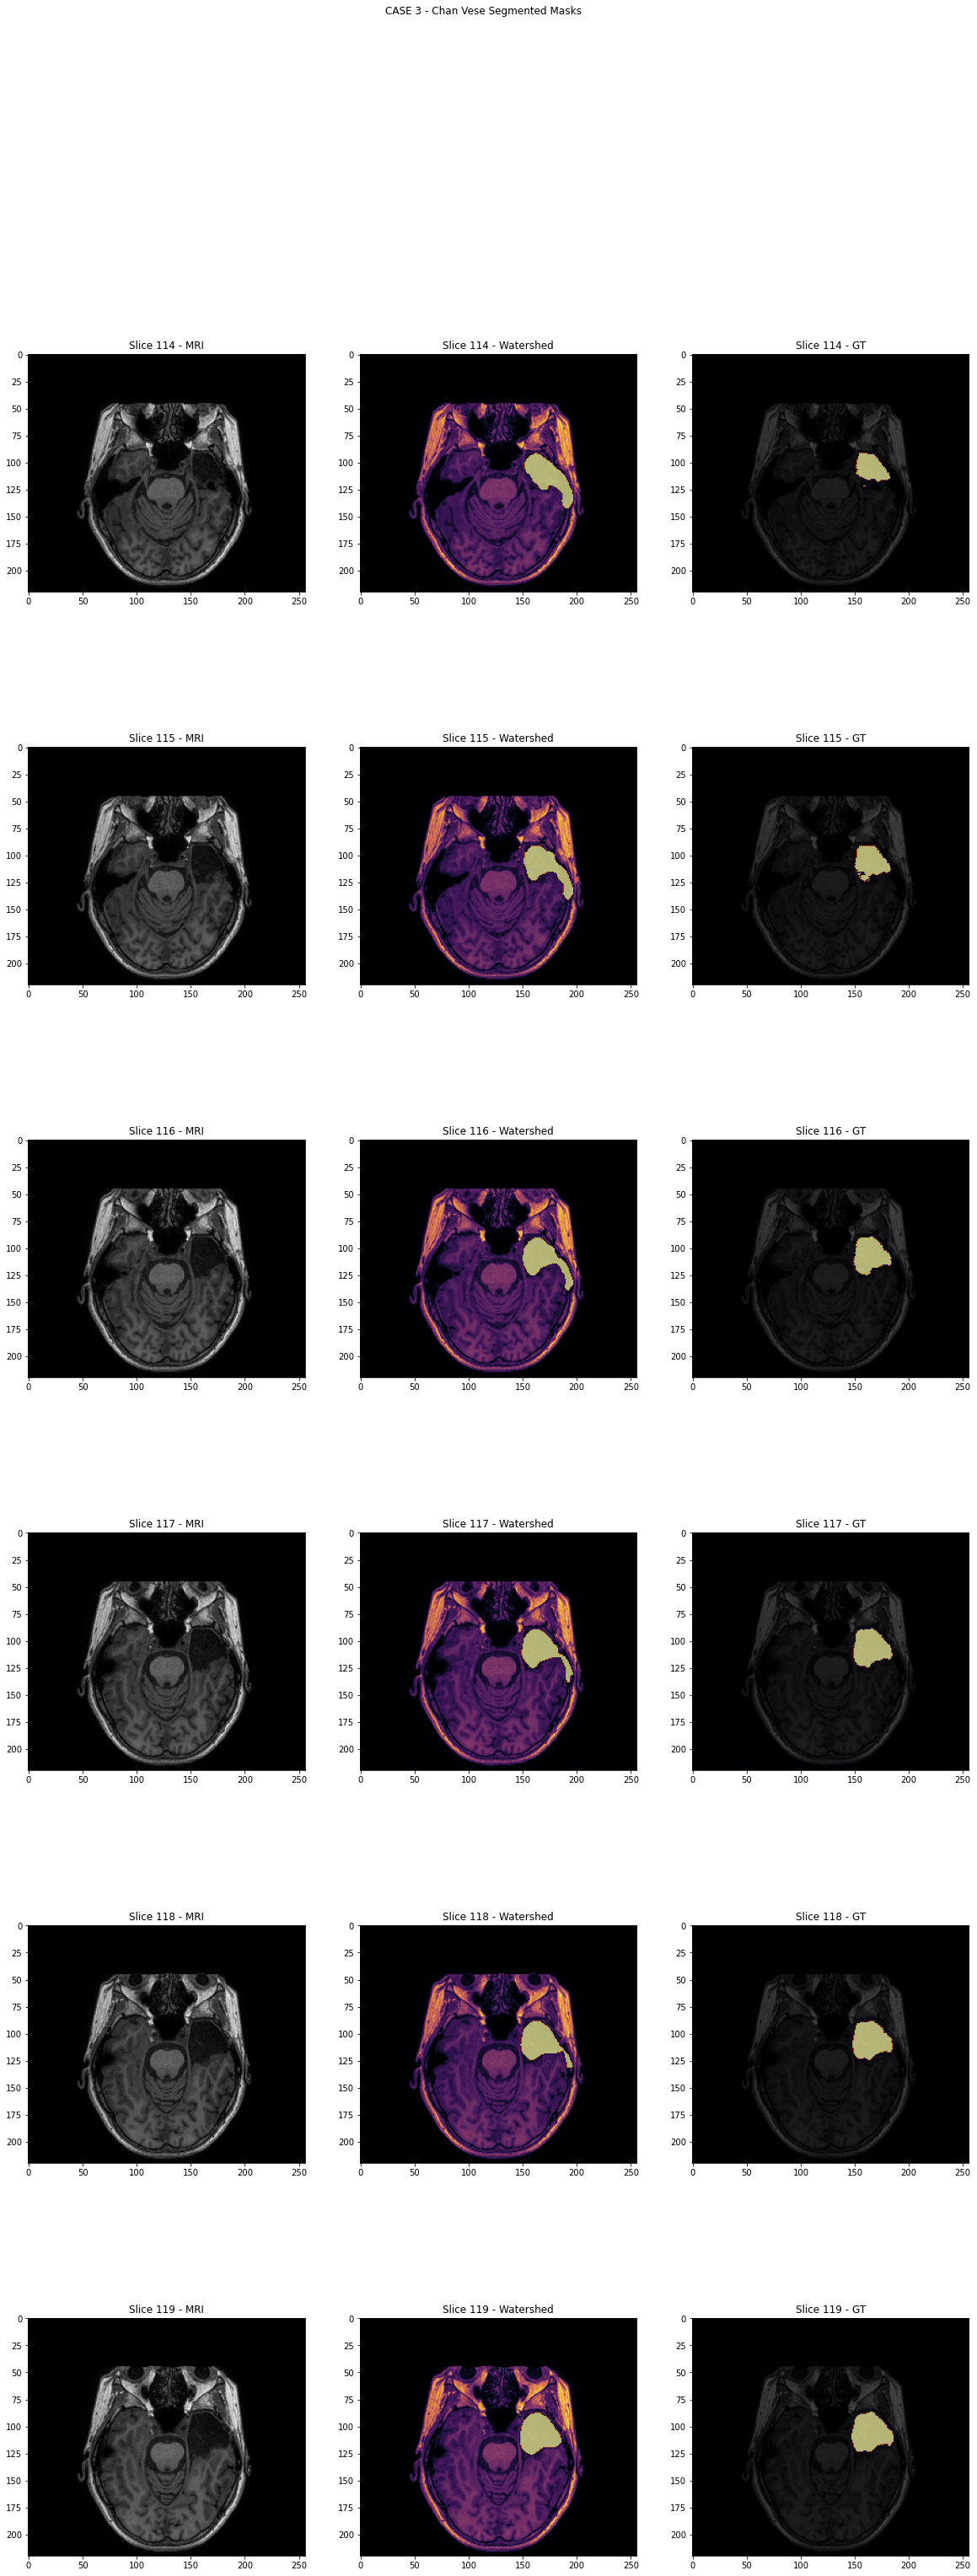

In [7]:
res_dict = {}
slices_result, dices_chan_vese = apply_batch_chan_vese(df, sub_id, slices_range, perspective, mu,
                                lambda1, lambda2, x, y, n_case)
dices_scores_cha_vese.append(dices_chan_vese)
res_dict[f'CASE{n_case}'] = {'chan_vese': dices_chan_vese}